In [1]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import datetime
import os, sys

from tensorboardX import SummaryWriter
from matplotlib.pyplot import imshow, imsave
%matplotlib inline





In [4]:
MODEL_NAME = 'infoGAN'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [5]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [6]:


def sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=None, supervised=False):
    z = torch.randn(batch_size, n_noise).to(DEVICE)
    if supervised:
        c_discrete = to_onehot(label).to(DEVICE) # (B,10)
    else:
        c_discrete = to_onehot(torch.LongTensor(batch_size, 1).random_(0, n_c_discrete)).to(DEVICE) # (B,10)
    c_continuous = torch.zeros(batch_size, n_c_continuous).uniform_(-1, 1).to(DEVICE) # (B,2)
    c = torch.cat((c_discrete.float(), c_continuous), 1)
    return z, c



In [7]:
def get_sample_image(border=1):
    """
        save sample 100 images
    """
    images = []
    # continuous code
    for cc_type in range(2):
        for num in range(10):
            fix_z = torch.randn(1, n_noise)
            z = fix_z.to(DEVICE)
            cc = -border
            for i in range(10):
                cc += 0.2*border
                c_discrete = to_onehot(num).to(DEVICE) # (B,10)
                c_continuous = torch.zeros(1, n_c_continuous).to(DEVICE)
                c_continuous.data[:,cc_type].add_(cc)
                c = torch.cat((c_discrete.float(), c_continuous), 1)
                y_hat = G(z, c)
                line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
            all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
        img = all_img.cpu().data.numpy()
        images.append(img)
    # discrete code
    for num in range(10):
        #c_discrete = to_onehot(num).to(DEVICE) # (B,10)
        for i in range(10):
            c_discrete = to_onehot(i).to(DEVICE) # (B,10)
            z = torch.randn(1, n_noise).to(DEVICE)
            c_continuous = torch.zeros(1, n_c_continuous).to(DEVICE)
            c = torch.cat((c_discrete.float(), c_continuous), 1)
            y_hat = G(z, c)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    images.append(img)
    return images[0], images[1], images[2]

In [8]:


def log_gaussian(c, mu, var):
    """
        criterion for Q(condition classifier)
    """
    return -((c - mu)**2)/(2*var+1e-8) - 0.5*torch.log(2*np.pi*var+1e-8)



In [9]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(# 28 -> 14
            nn.Conv2d(in_channel, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(# 14 -> 7
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3 = nn.Sequential(#
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    
    def forward(self, x):
        y_ = self.layer1(x)
        y_ = self.layer2(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.layer3(y_)
        d = self.fc(y_) # Real / Fake        
        return d, y_ # return with top layer features for Q

In [10]:


class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=62, code_size=12, num_classes=784):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size+code_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(# input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(# input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            #nn.ReLU()
            nn.Tanh(),
        )
        
    def forward(self, z, c):
        z = z.view(z.size(0), -1)
        c = c.view(c.size(0), -1)
        noise = torch.cat((z, c), 1)
        x_ = self.layer1(noise)
        x_ = self.layer2(x_)
        x_ = x_.view(x_.size(0), 128, 7, 7)
        x_ = self.layer3(x_)
        x_ = self.layer4(x_)
        return x_



In [28]:
class ConcatLayer(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x, y):
        return torch.cat((x, y), self.dim)



class Mine(nn.Module):
    
    def __init__(self, sample_size=28*28, noise_size=12, output_size=1, hidden_size=128):
        super().__init__()
        self.layer1 = nn.Sequential(# 28 -> 14
            nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        )
        self.layer2 = nn.Sequential(# 14 -> 7
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )
        self.layer3 = nn.Sequential(#
            nn.Linear(128*7*7+noise_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
        )   

        self.fc = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 12),
        )
        self.flatten = nn.Flatten()
        self.cat = ConcatLayer()
                
    def forward(self, sample, noise):
        x_s = self.layer1(sample)
        x_s = self.layer2(x_s)
        flattened_sample = self.flatten(x_s)
        x = self.cat(flattened_sample, noise)
        x = self.layer3(x)
        x = self.fc(x)
        discrete = x[:10]
        cont = x[10:]
        
        return discrete, cont



class OldMine(nn.Module):
    
    def __init__(self, sample_size=28*28, noise_size=12, output_size=1, hidden_size=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1, bias=False)
        self.flatten = nn.Flatten()
        self.cat = ConcatLayer()
        self.layer1 = nn.Linear(64*4*4 + noise_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.activation1 = nn.LeakyReLU(0.1)
        self.layer3 = nn.Linear(512, 256)      
        self.bn3 = nn.BatchNorm1d(256)
        self.layer4 = nn.Linear(256, 12)
        self.activation2=nn.ReLU()
        

        #self.layer1 = nn.Linear(sample_size + noise_size, 400)
        #self.layer2 = nn.Linear(400, 400)
        #self.layer3 = nn.Linear(400, 400)
        #self.layer4 = nn.Linear(400, 12)
        #self.activation = nn.ReLU()

                
    def forward(self, sample, noise):
        x_s = self.conv1(sample)
        x_s = self.activation2(x_s)
        x_s = self.conv2(x_s)
        x_s = self.activation2(x_s)
        x_s = self.conv3(x_s)
        x_s = self.activation2(x_s)
        flattened_sample = self.flatten(x_s)
        x = self.cat(flattened_sample, noise)
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.activation1(x)
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.activation1(x)
        #x = self.layer3(x)
        #x = self.bn3(x)
        #x = self.activation1(x)
        x = self.layer4(x)
        #x = self.activation(x)
        discrete = x[:10]
        cont = x[10:]
        
        return discrete, cont

In [29]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
M = Mine().to(DEVICE)

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [30]:
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

D_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.99))
G_opt = torch.optim.Adam([{'params':G.parameters()}, {'params':M.parameters()}], lr=1e-3, betas=(0.5, 0.99))
#G_opt = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.99))

M_opt = torch.optim.Adam(M.parameters(), lr=1e-4)
max_epoch = 50 # need more than 200 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 62
n_c_discrete, n_c_continuous = 10, 2

D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake



In [31]:
def fro_norm(model, eps=1e-8):
  params = model.parameters()
  total_norm = 0
  for p in params:
    if p.grad is None:
      continue
    param_norm = p.grad.data.norm(p='fro')
    total_norm += param_norm**2
  total_norm = total_norm**0.5
  return total_norm

def adaptive_clip_grad(M_model, G_norm, M_norm, eps=1e-8):
    parameters = [p for p in M_model.parameters() if p.requires_grad]
    if M_norm > 0.15:
      clip_grad(M_model)
      
    clip_coef = min(G_norm, M_norm)/(M_norm + eps)
    for p in parameters:
          p.grad.detach().mul_(clip_coef.to(p.grad.device))


def clip_grad(model, eps=1e-8):
    parameters = [p for p in model.parameters() if p.requires_grad]
    my_fro_norm = fro_norm(model)
    if my_fro_norm > 0.15:
      clip_coef = 0.15 / my_fro_norm
      for p in parameters:
        p.grad.detach().mul_(clip_coef.to(p.grad.device))

In [16]:
os.mkdir("samples")

In [32]:
for epoch in range(max_epoch+1):
    for idx, (images, labels) in enumerate(data_loader):
        step += 1
        labels = labels.view(batch_size, 1)
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs, _, = D(x)
        D_x_loss = bce_loss(x_outputs, D_labels)

        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        z_outputs, _, = D(G(z, c))
        D_z_loss = bce_loss(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z, c = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)
        #c_discrete_label = torch.max(c[:, :-2], 1)[1].view(-1, 1)
        #print(torch.max(c[:, :-2], 1))

         # (B,1), (B,10), (B,4)
        gen_output = G(z, c)
        z_outputs, features = D(gen_output) 

        G_loss = bce_loss(z_outputs, D_labels)  #D_labels

        _, c_bar = sample_noise(batch_size, n_noise, n_c_discrete, n_c_continuous, label=labels, supervised=True)

        
        M_c_disc, M_c_cont = M(gen_output, c)
        M_c_bar_disc, M_c_bar_cont = M(gen_output, c_bar)
        
        mi_discrete = torch.mean(M_c_disc) - torch.log(torch.mean(torch.exp(M_c_bar_disc)+1e-8))
        mi_cont1 = torch.mean(M_c_cont[0]) - torch.log(torch.mean(torch.exp(M_c_bar_cont[0])+1e-8))
        mi_cont2 = torch.mean(M_c_cont[1]) - torch.log(torch.mean(torch.exp(M_c_bar_cont[1])+1e-8))
        mutual_info_loss = -1*(mi_discrete + mi_cont1 + mi_cont2)
        
       
        if -1*mutual_info_loss.item() > 20:
          GnQ_loss = G_loss
        else:
          GnQ_loss = G_loss + mutual_info_loss

        #print(Q_loss_discrete)
        
        #M_opt.zero_grad()
        #mutual_info_loss.backward(retain_graph=True) # This or GnQ loss?
        #M_opt.step()
   
        G_opt.zero_grad()
        GnQ_loss.backward()
        G_grad_norm = fro_norm(G)
        MI_grad_norm = fro_norm(M)
        adaptive_clip_grad(M, G_grad_norm, MI_grad_norm)
        #clip_grad(G)
        G_opt.step()
        
        if step % 500 == 0:
            print(MI_grad_norm.item())
            print(f"discrete: {mi_discrete}")
            print(f"cont 1: {mi_cont1}, cont 2: {mi_cont2}")
            print('Epoch: {}/{}, Step: {}, Mut info: {}, D Loss: {}, G Loss: {}, GnQ Loss: {}, Time: {}'\
                  .format(epoch, max_epoch, step, -1*mutual_info_loss.item(), D_loss.item(), G_loss.item(), GnQ_loss.item(), str(datetime.datetime.today())[:-7]))
            
        if step % 1000 == 0:
            G.eval()
            img1, img2, img3 = get_sample_image()
            imsave('samples/{}_step{}_type1.jpg'.format(MODEL_NAME, str(step).zfill(3)), img1, cmap='gray')
            imsave('samples/{}_step{}_type2.jpg'.format(MODEL_NAME, str(step).zfill(3)), img2, cmap='gray')
            imsave('samples/{}_step{}_type3.jpg'.format(MODEL_NAME, str(step).zfill(3)), img3, cmap='gray')
            G.train()


0.05117610841989517
discrete: 0.0008155708201229572
cont 1: 0.0007049357518553734, cont 2: 0.0005813294555991888
Epoch: 0/50, Step: 500, Mut info: 0.0021018360275775194, D Loss: 1.1162011623382568, G Loss: 0.9442410469055176, GnQ Loss: 0.942139208316803, Time: 2023-03-15 21:41:37
0.018081072717905045
discrete: -5.926564335823059e-05
cont 1: 5.922000855207443e-05, cont 2: 9.100139141082764e-05
Epoch: 1/50, Step: 1000, Mut info: 9.095575660467148e-05, D Loss: 1.176849126815796, G Loss: 0.982959508895874, GnQ Loss: 0.9828685522079468, Time: 2023-03-15 21:41:58
0.011427044868469238
discrete: -0.0002534922678023577
cont 1: 0.000404782360419631, cont 2: 4.817452281713486e-05
Epoch: 1/50, Step: 1500, Mut info: 0.0001994646154344082, D Loss: 1.1415364742279053, G Loss: 1.0031706094741821, GnQ Loss: 1.0029711723327637, Time: 2023-03-15 21:42:19
0.011533470824360847
discrete: -0.00016500195488333702
cont 1: 7.126806303858757e-05, cont 2: -0.000296284444630146
Epoch: 2/50, Step: 2000, Mut info: -

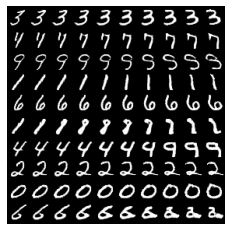

In [55]:
import matplotlib.pyplot as plt
G.eval()
plt.imshow(get_sample_image(2)[1], cmap='gray')
plt.axis('off')
plt.savefig('MINE_tilt.jpg', dpi=600, bbox_inches='tight')

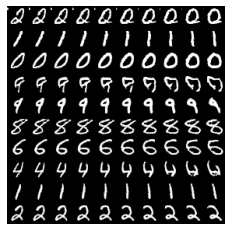

In [53]:
import matplotlib.pyplot as plt
G.eval()
plt.imshow(get_sample_image(2)[0], cmap='gray')
plt.axis('off')
plt.savefig('MINE.jpg', dpi=600, bbox_inches='tight')

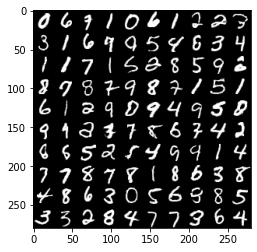

In [50]:
import matplotlib.pyplot as plt
G.eval()
plt.imshow(get_sample_image(2)[2], cmap='gray')

In [ ]:
a, b, c=get_sample_image()